# <font color='#505050'>Organizations should move from frequentist approach of A/B testing towards the Bayesian framework</font>  

> <p><b>The aim of this notebook is to encourage organizations to adopt Bayesian experimentation by demonstrating the advantages of Bayesian framework over the frequentist one</b></p>

## <font color='brown'>Use Case:</font>  
Let's say LinkedIn wants to increase its conversion ratio when a customer clicks on “LinkedIn Premium” button. The underlying assumption is that the layout, information and other page factors are affecting the conversion ratio. Let’s call this current variant “A”. Thus, we want to run an A/B test comparing the performance of variant “A” with a different variant “B”. Please note that this is an imaginary hypothetical usecase with LinkedIn as an example.

### <font color='teal'>Introduction:</font> 
LinkedIn decides to conduct an experiment where, the site sends the user to one of two (or possibly more) different pages when a user clicks on “LinkedIn premium” button. The purpose is to determine which page version generates a superior outcome, i.e. which page generates more number of conversions. This notebook will showcase an end to end solution for the Frequentist as well as the Bayesian approach. The entire notebook is divided in **following parts**:
    


<font color='#3E3E3F'><b>1. Clear advantages of Bayesian approach </b></font> 

<font color='#3E3E3F'><b>2. Comparing Frequentist vs Bayesian: Results and interpretations </b></font> 

<font color='#3E3E3F'><b>3. Layout of steps taken in both Frequentist and Bayesian approach </b></font> 

<font color='#3E3E3F'><b>4. Detailed steps taken for both the approaches</b></font> 

<font color='#3E3E3F'><b>5. Recommendations and next steps </b></font> 

<font color='#3E3E3F'><b>6. References </b> </font> 



## <font color='brown'>1. Clear advantages of Bayesian approach</font> 

Extreme experimentation is one of the keys to unlock the success of a company. More we experiment, more are the learnings and better are the chances of identifying the true needs of customer. 

Companies have historically been using frequentist/classical methods for testing out different hypotheses (for example finding a winner version of a website from two variants). Based on this approach decisions are been made towards a successful customer - company relationship. General difficulty is usually faced by the product analysts to explain the results of the experiment such as p values and confidence intervals to business and can be a daunting task. Here the analyst has to explain the results as “ Since the p value is less than 0.05, we can reject the null hypothesis. We believe the evidence we saw was unlikely to appear 95% of the times if null hypothesis were true. We thus reject the null hypothesis.”

**What business actually wants to actually hear is "probability of variant B being better than A is x%"**

Lucky for us that there exists a way where we can lower the cost of experimentation by making decision approximately 50% faster than usual, and where an analyst can dare to actually say the following words out loud “Based not the data, the probability of conversion from ‘B’ being higher than A is 80% (for example)’ “. Not only this, we can continually measure our results as opposed to a fixed sample size design offering more transparency	.

This extraordinary way is offered to us by Bayesian framework. We can use bayesian estimation and sequential Bayes factor methods to design our experiment and measure our desired outcomes.

Below are the clear cut advantages that Bayesian approach holds over Frequentist methods:


**I. Sample size required to reach a decision is 50% that of the frequentist approach (Graph 1) (<a href="https://osf.io/w3s3s/download"> White paper </a>)**

**II. Interpretability: Simple and intutive interpretaion of the results** 

**III. We can comment about the actual probabilities of the conversion rates for both the variants** 

**IV. Bayesian Framework enables a continuous measurement as compared to frequentist methods where peeking often leads to p value hacking, which is a questionable practice**

**Results observed in this use case -**

> *Frequentist :"As we observe a significant p value of 0.02, we can reject the null hypothesis"*

> *Bayesian: "There is 95% probability that version 'A' is better than version 'B' and expected lift in conversion rate is 1.2 percentage points*

This notebook entails a detail walkthrough of the approach taken to reach these results in both the frameworks

## <font color='brown'>2. Comparing Frequentist vs Bayesian: Results and interpretations</font> 

> **The graph below (Graph 1) represents the contrast in number of days it took to reach a decision through both the approaches**

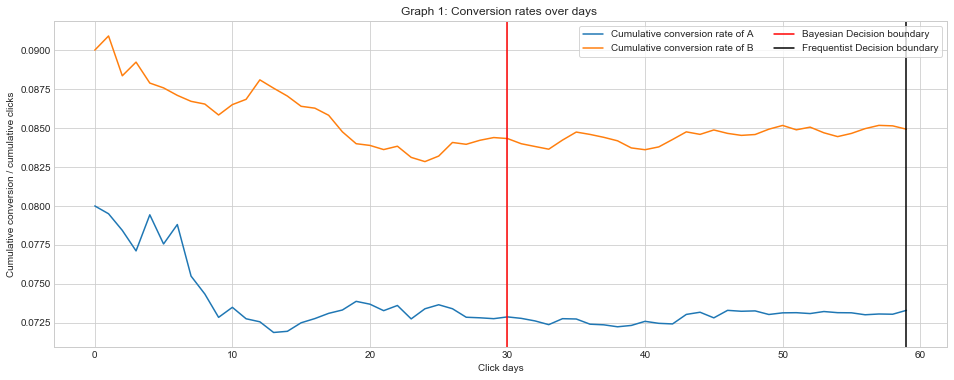

In [32]:
# Will be explaining the approach to results and dataframe used in next section of "Elaborate steps takes"
fig, ax = plt.subplots(figsize=(16,6))
plt.style.use('seaborn-whitegrid')
ax.plot(conv_days['click_day'], conv_days['cumu_rate_a'], label = 'Cumulative conversion rate of A')
ax.plot(conv_days['click_day'],conv_days['cumu_rate_b'], label = 'Cumulative conversion rate of B')
ax.set_title('Graph 1: Conversion rates over days ')
ax.set_ylabel('Cumulative conversion / cumulative clicks')
ax.set_xlabel('Click days')
legend = ax.legend(loc = 'upper right',ncol=1,frameon = True)

xcoords = [30, 59]
# colors for the lines
colors = ['r','k']
decision_boundary = ['Bayesian Decision boundary', 'Frequentist Decision boundary']
for xc,c,db in zip(xcoords,colors,decision_boundary):
    ax.axvline(x=xc, label='{}'.format(db), c=c)
    ax.legend(loc = 'upper right',ncol=2,frameon = True)
    
plt.show()

### <font color='teal'>2.1 A high level comparision of the two approaches </font> 

There are two well-known branches of statistics: Frequentist statistics and Bayesian statistics. These two branches have plenty of differences, but we're going to focus on one key difference:

<ul style="list-style-type:disc;">
 <p> <li>In frequentist statistics, we assume the parameter(s) of interest are fixed constants. We focus on computing the likelihood $p(Data∣Parameter)$, the probability we see the observed set of data points given the parameter of interest.</li></p>
   
 <p> <li>In Bayesian statistics, we having uncertainty surrounding our parameter(s) of interest, and we mathematically capture our prior uncertainty about these parameters in a prior distribution, formally represented as $p(Parameter)$. We focus on computing the posterior distribution $p(Parameter∣Data)$, representing our posterior uncertainty surrounding the parameter of interest after we have observed data.</li></p>
</ul>


Put it in another way, when using frequentist statistics, you based your decision on whether A beats B only from the data in the test. All other information is irrelevant as we are simply testing A against B. And nothing else is relevant.

On the other hand, the Bayesian approach lets you to think a bit deeper about the problem. When we're testing A against B we actually do have some other information. We know what makes sense. And this is valuable information when making a decision.

For A/B testing, what this means is that the product manager, has to come up with what conversion rate makes sense, known as the prior. That is, if we typically see 8% conversion in A, then we would not, during the test, expect to see it at 100%.

Then instead of only finding the winner in the test itself, Bayesian analysis will include our prior knowledge into the test. That is, we can tell the test what we believe the right answer to be - and then using that prior knowledge, the test can tell us whether A beats B. And, because it uses more information than what's in the test itself, it can give us a defensible answer as to whether A beat B from a remarkably small sample size.

### <font color='teal'>2.2 Interpretaion of frequentist results - what it means and what it doesn't: </font> 

Frequentist statistic's hypothesis testing uses a p-value to weigh the strength of the evidence (what the data is telling you about the population). p-value is defined as the probability of obtaining the observed or more extreme outcome, given that the null hypothesis is true (not the probability that the alternative hypthesis is true). It is a number between 0 and 1 and interpreted in the following way:

A small p-value (typically <= 0.05, 0.05 is a commonly used threshold, the threshold is often denoted as  α) indicates strong evidence against the null hypothesis, so we reject the null hypothesis. This means that something interesting is going on and it’s not just noise!
A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so we fail to reject the null hypothesis. Although p-value is still in our favor, we cannot conclusively say that it was not due to random noise.
p-values very close to the cutoff (0.05) are considered to be marginal (could go either way). 

A point estimate can give us a rough idea of a population parameter like the mean, but estimates are prone to error. A confidence interval is a range of values above and below a point estimate that captures the true population parameter at some predetermined confidence level. For example, if you want to have a 95% chance of capturing the true population parameter with a point estimate and a corresponding confidence interval, we'd set our confidence level to 95%. Higher confidence levels result in a wider confidence intervals.

More formally, the definition of a 95% confidence interval means that 95% of confidence intervals, created based on random samples of the same size from the same population will contain the true population parameter.

### <font color='teal'>2.3 Interpretation of bayesian results:  </font> 

As we gather data, we compute a posterior probability distribution on the click through rate of version A and B. What this means is that we compute a graph which represents the places where we think the true click through rate might live using the data we’ve collected.

We don't get a single conversion rate as a posterior probability but multiple conversion rates and and probabilities attached to it. This captures the prevailing uncertainity about conversion rates that is present in reality but is often ignored in frequentist calculations.

So the posterior distribution (that we will calculate later) will give us a probability distribution of conversion rates of both the variants based on the observed data. 

Once we have the posterior distributions, we can infer results like "probability of version 'A' being better than version 'B' is x% "

Similar but superior to confidence intervals, we have *credible intervals* where we give a range of values in which our conversion rate is most likely to lie (aspect similar to frequentist) along with the probability distribution of the values in the interval (aspect superior to frequentist)

## <font color='brown'>3. Layout of steps taken in both Frequentist and Bayesian approach</font>

### <font color='teal'>3.1 Steps taken in frequentist approach</font> 

1. Deciding the outcome / success criteria for the test
2. Deciding the effect size that we want to detect
3. Decide significance level & power level
4. Estimate number of samples (based on assumptions of effect size and power level)
5. Estimate number of days to collect the said samples
6. Measuring of results - Significant or not? 

### <font color='teal'>3.2 Steps taken in bayesian approach</font> 

<font color = '#3E3E3F'><b>3.2.1 Steps taken are:</b></font>
1. Collect information about how the prior distribution looks like (not a necissity; we can use ininformed priors)
2. Deciding the decision boundary (for e.g. we want to 90% sure that version A is better than B)
3. Collecting the data
4. Calculating the posterior distribution for conversion rates of both the variants
5. Inference


<font color = '#3E3E3F'><b>3.2.2 A bit more context:</b></font> 

We are interested in beliefs, which can be interpreted as probabilities by thinking Bayesian. We have a *prior* belief in event $A$, beliefs formed by previous information, e.g., our prior belief about what generally are the conversion rates before performing tests.

Secondly, we observe our evidence. If we observe $X$ conversions, we want to update our belief to incorporate this. We call this new belief the **_*posterior*_** probability. Updating our belief is done via the following equation, known as Bayes' Theorem, after its discoverer Thomas Bayes:

\begin{align}
  P( A | X ) = & \frac{ P(X | A) P(A) } {P(X) } \\\\[5pt]
 & \propto P(X | A) P(A)\;\; (\propto \text{is proportional to } )
 \end{align}
 
The above formula is not unique to Bayesian inference: it is a mathematical fact with uses outside Bayesian inference. Bayesian inference merely uses it to connect prior probabilities $P(A)$ with an updated posterior probabilities $P(A | X )$.

## <font color='brown'>4. Detailed steps taken for both the approaches</font> 

### <font color='teal'>4.1 Generating data for the Experiment (for both frequentist and bayesian approach) </font> 

#### <font color = '#3E3E3F'>4.1.1 Importing libraries</font>

In [1]:
import pandas as pd
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportions_chisquare
import scipy.stats as stats
from scipy.stats import beta
from statsmodels.stats.power import TTestIndPower
import time

#### <font color = '#3E3E3F'>4.1.2 Defining function for generating campaign data</font>

In [2]:
def gen_campaigns(p1,p2,nb_days,scaler,seed):
    #generate fake data
    np.random.seed(seed)
    ns = np.random.triangular(50,100,150,size=120).astype(int)
    np.random.seed(seed)
    es = np.random.randn(nb_days*2) / scaler

    n1 = ns[:nb_days]
    c1 = ((p1 + es[:nb_days]) * n1).astype(int)
    n2 = ns[nb_days:]
    c2 = ((p2 + es[nb_days:]) * n2).astype(int)
    conv_days = pd.DataFrame({'click_day':range(nb_days),'click_a':n1,'conv_a':c1,'click_b':n2,'conv_b':c2})

    conv_days =  conv_days[['click_day','click_a','click_b','conv_a','conv_b']]
    conv_days['cumu_click_a'] = conv_days.click_a.cumsum()
    conv_days['cumu_click_b'] = conv_days.click_b.cumsum()
    conv_days['cumu_conv_a'] = conv_days.conv_a.cumsum()
    conv_days['cumu_conv_b'] = conv_days.conv_b.cumsum()
    conv_days['cumu_rate_a'] = conv_days.cumu_conv_a / conv_days.cumu_click_a
    conv_days['cumu_rate_b'] = conv_days.cumu_conv_b / conv_days.cumu_click_b
    conv_days['daily_conv_rate_a'] = conv_days.conv_a/conv_days.click_a
    conv_days['daily_conv_rate_b'] = conv_days.conv_b/conv_days.click_b
    return conv_days

#### <font color = '#3E3E3F'>4.1.3 Generating fake data</font>

In [3]:
#generating data
conv_days = gen_campaigns(p1 = 0.08,
                          p2 = 0.092, # true conversion rates; that we won't have this information in reality
                          nb_days = 60,
                          scaler=100,
                          seed = 1412) 
conv_days.head()

,click_day,click_a,click_b,conv_a,conv_b,cumu_click_a,cumu_click_b,cumu_conv_a,cumu_conv_b,cumu_rate_a,cumu_rate_b,daily_conv_rate_a,daily_conv_rate_b
0,0,125,100,10,9,125,100,10,9,0.080000,0.090000,0.080000,0.090000
1,1,114,54,9,5,239,154,19,14,0.079498,0.090909,0.078947,0.092593
2,2,67,95,5,8,306,249,24,22,0.078431,0.088353,0.074627,0.084211
3,3,96,76,7,7,402,325,31,29,0.077114,0.089231,0.072917,0.092105
4,4,89,96,8,8,491,421,39,37,0.079430,0.087886,0.089888,0.083333


#### <font color = '#3E3E3F'>4.1.4 Plot of campaign data over days</font>

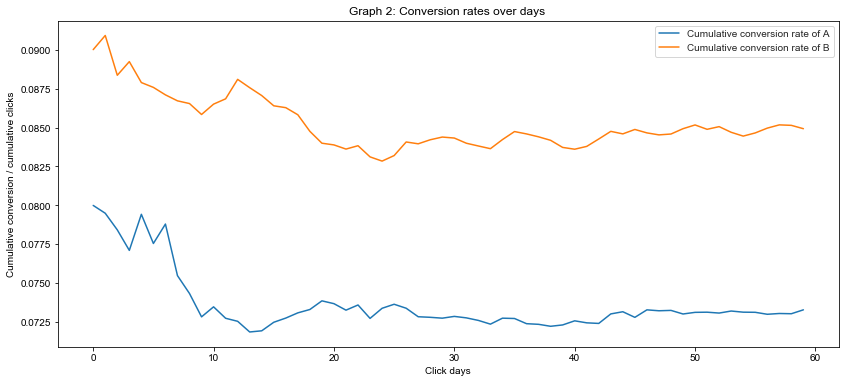

In [4]:
fig, ax = plt.subplots(figsize=(14,6))
plt.style.use('seaborn-whitegrid')
ax.plot(conv_days['click_day'], conv_days['cumu_rate_a'], label = 'Cumulative conversion rate of A')
ax.plot(conv_days['click_day'],conv_days['cumu_rate_b'], label = 'Cumulative conversion rate of B')
ax.set_title('Graph 2: Conversion rates over days ')
ax.set_ylabel('Cumulative conversion / cumulative clicks')
ax.set_xlabel('Click days')
legend = ax.legend(loc = 'best',ncol=1,frameon = True)
plt.show()

#### <font color = '#3E3E3F'>4.1.5 Overall campaign data </font>

In [5]:
campaign = pd.DataFrame({'Campaign_ID':['A','B'], 'Clicks': [conv_days.click_a.sum(),
                                                               conv_days.click_b.sum()],
                        'Conversion': [conv_days.conv_a.sum(),conv_days.conv_b.sum()],
                        'Conversion_pct': [conv_days.conv_a.sum()/conv_days.click_a.sum(),
                                           conv_days.conv_b.sum()/conv_days.click_b.sum()]})
campaign.head()

,Campaign_ID,Clicks,Conversion,Conversion_pct
0,A,5921,434,0.073298
1,B,5864,498,0.084925


####  <font color = '#3E3E3F'>4.1.6 Information that we will have at the end of the campaign</font>

We are looking at the stats after 59 days. How did we arrive at the number of days? Explaination is in below sections

In [6]:
# Generic code chunk to extract cumulative clicks and conversions on a daily basis - to be used in both the approaches
click_day = 59
success_a = conv_days.loc[conv_days['click_day'] == click_day]['cumu_conv_a'].values[0]
size_a = conv_days.loc[conv_days['click_day'] == click_day]['cumu_click_a'].values[0]
success_b = conv_days.loc[conv_days['click_day'] == click_day]['cumu_conv_b'].values[0]
size_b = conv_days.loc[conv_days['click_day'] == click_day]['cumu_click_b'].values[0]


prop_a = success_a / size_a
prop_b = success_b / size_b
print('Total conversion rate for version "A" for this campaign is {:.3f} \
\nTotal conversion rate for version "B" for this campaign is {:.3f}'.format(prop_a,prop_b))

Total conversion rate for version "A" for this campaign is 0.073 
Total conversion rate for version "B" for this campaign is 0.085


###  <font color='teal'>4.2 Frequentist Approach </font> 

Effect size assumptions, power and sample size calculations will enable us to take into account the business constraints and help us design the experiment in an efficient way (for example: how long an experiment should run vs what is the minimum effect size we want to detect?)

<font color = '#3E3E3F'><b>4.2.1 Effect sizes: Maths to business translation:</b></font>

Usually effect size (also known as cohen's d) is a standardize difference of means between two group that we want to detect. It is represented by equation:

$$effect\ size = (mean\ of\ experiment\ group\ - mean\ of\ control\ group)/\ Standard\ deviation $$

But how does this translate when we are talking about proportions? For these purposes, we have Cohen's h

$$ℎ=2∗𝑎𝑟𝑐𝑠𝑖𝑛(√𝑝_1)−2∗𝑎𝑟𝑐𝑠𝑖𝑛(√𝑝_2)$$

To continue our LinkedIn example: The Product manager knows or has agreed on a base conversion rate of 8% (i.e. the current state). Now he wants to detect if there is a true increase in conversion rate (we are referring to it as minimum difference) by 1.5% points. Now our next step is to find the corresponding the effect size for this business requirement.

<font color = '#3E3E3F'><b>4.2.2 Translating business constraints to maths (i.e. effect size)</b></font>

In [7]:
import math

prob_a = 0.08
min_diff = 0.012
prob_b = prob_a + min_diff

arsine_transformation_p1 = 2*math.asin(np.sqrt(prob_a))
arsine_transformation_p2 = 2*math.asin(np.sqrt(prob_b))

cohens_h = abs(arsine_transformation_p1-arsine_transformation_p2)
print('To detect an increase in 1.2 percentage points in conversion rate, the corresponding effect size to be used for \nsample size estimation is {:.3f}'.format(cohens_h))


To detect an increase in 1.2 percentage points in conversion rate, the corresponding effect size to be used for 
sample size estimation is 0.043


#### <font color = '#3E3E3F'>4.2.3 Sample size Curve</font>

Below is a sample size vs cohen's d graph. This indicates that the to detect a smaller effect size, larger number of sample sizes are required and it increases exponentially if we want to detect even smaller differences

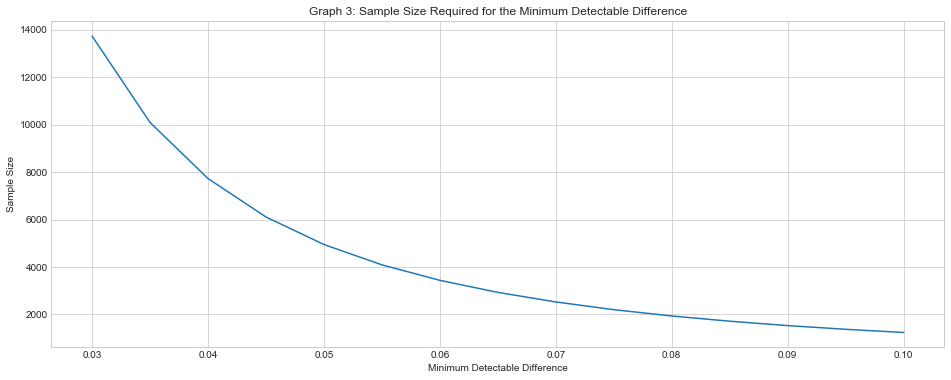

In [8]:
#Power curve

# calculate the the required sample size
# for a range of minimum detectable difference and a set power and significance level
power = 0.8 # Below graph will be for a constant power of 80%
alpha = 0.05 # and a given significance level
sample_sizes = []
effect_sizes = np.arange(0.03, 0.1, 0.005)
for effect in effect_sizes:
    sample_size = TTestIndPower().solve_power(effect, power=power, nobs1=None, ratio=1.0, alpha=alpha, alternative = 'larger')
    sample_sizes.append(sample_size)

fig, ax = plt.subplots(figsize=(16,6))
ax.plot(effect_sizes, sample_sizes)
ax.set_title('Graph 3: Sample Size Required for the Minimum Detectable Difference')
ax.set_ylabel('Sample Size')
ax.set_xlabel('Minimum Detectable Difference')
#ax.set_tight_layout()
plt.show()


####  <font color = '#3E3E3F'>4.2.4 Calculating the sample size for the Experiment</font>

In [9]:
# Assuming the minimum detectable difference as 1.2% i.e. effect size = 0.046

#assumptions for type I error = 5% alpha
#assumpions for type II error = 20% beta
# Power = 80% (1-type II error)

#Power and sample size calculations

# estimate sample size via power analysis
from statsmodels.stats.power import TTestIndPower
# parameters for power analysis
effect = 0.046
alpha = 0.05
power = 0.8
# perform power analysis
analysis = TTestIndPower()
result = TTestIndPower().solve_power(effect, power=power, nobs1=None, ratio=1.0, alpha=alpha, alternative = 'larger')
print('Sample Size for one group: %.3f' % result)

Sample Size for one group: 5844.303


####   <font color = '#3E3E3F'>4.2.5 Power curve</font>

Power of a test is defined as being able to correctly detect an effect provided an effect really exists. For e.g. 80% power means that we would be able to detect an effect (pre decided effect) if the effect really exists. The below plot will help us understand what is the trade off between power and sample size for a given minimum difference (effect) 

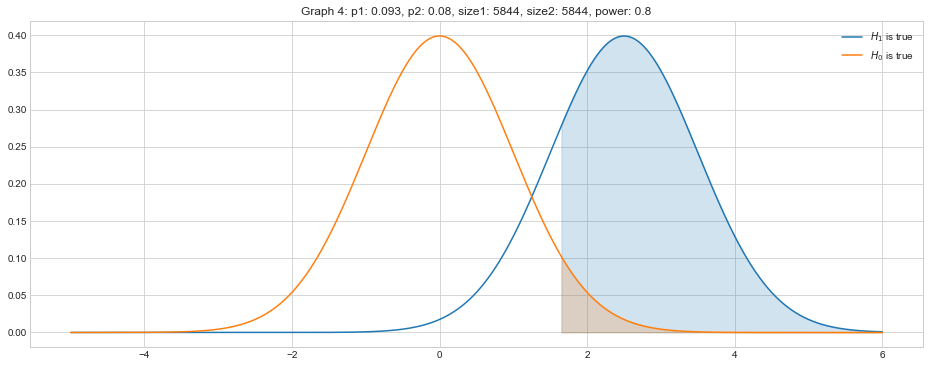

In [10]:
#H0 and H1 distribution plot with power

def plot_power(min_diff, prob_b, size_a, size_b, significance = 0.05):
    """illustrating power through a one-tailed hypothesis test"""
    
    # obtain the z-score for the minimum detectable
    # difference using proportion_ztest
    prob_a = prob_b + min_diff
    count_a = size_a * prob_a
    count_b = size_b * prob_b
    counts = np.array([count_a, count_b])
    nobs = np.array([size_a, size_b])
    zscore, _ = proportions_ztest(counts, nobs, alternative = 'larger')

    # distribution for the null hypothesis, h0
    # and alternative hypothesis, h1
    h0 = stats.norm(loc = 0, scale = 1)
    h1 = stats.norm(loc = zscore, scale = 1)

    # points that are greater than the zscore for the
    # specified significance level
    x = np.linspace(-5, 6, num = 1000)
    threshold = h0.ppf(1 - significance)
    mask = x > threshold
    
    # power is the area after the threshold, i.e.
    # 1 - the cumulative distribution function of that point
    power = np.round(1 - h1.cdf(threshold), 2)

    hypotheses = [h1, h0]
    labels = ['$H_1$ is true', '$H_0$ is true']
    fig, ax = plt.subplots(figsize=(16,6))
    for hypothesis, label in zip(hypotheses, labels):
        y = hypothesis.pdf(x)
        line = plt.plot(x, y, label = label)  
        plt.fill_between(x = x[mask], y1 = 0.0, y2 = y[mask],
                         alpha = 0.2, color = line[0].get_color())
    title = 'Graph 4: p1: {}, p2: {}, size1: {}, size2: {}, power: {}'
    ax.set_title(title.format(prob_a, prob_b, size_a, size_b, power))
    ax.legend()
    #ax.tight_layout()
    plt.show()

# running the function
prob_b = 0.08
min_diff = 0.013
size_a = 5844
size_b = 5844

plot_power(min_diff, prob_b, size_a, size_b)

#### <font color = '#3E3E3F'>4.2.6 Experiment run time</font>

In [11]:
experiment_runtime = min(conv_days.loc[(conv_days['cumu_click_b']> result ) & (conv_days['cumu_click_b'] > result)].click_day)
print('We have to run the experiment for minimum of %.f days' %experiment_runtime)

We have to run the experiment for minimum of 59 days


#### <font color = '#3E3E3F'>4.2.7 Measurement of the results after 59 days</font>

In [12]:
def two_proprotions_test(success_a, size_a, success_b, size_b):
    """
    A/B test for two proportions;
    given a success a trial size of group A and B compute
    its zscore and pvalue
    
    Parameters
    ----------
    success_a, success_b : int
        Number of successes in each group
        
    size_a, size_b : int
        Size, or number of observations in each group
    
    Returns
    -------
    zscore : float
        test statistic for the two proportion z-test

    pvalue : float
        p-value for the two proportion z-test
    """
    prop_a = success_a / size_a
    prop_b = success_b / size_b
    prop_pooled = (success_a + success_b) / (size_a + size_b)
    var = prop_pooled * (1 - prop_pooled) * (1 / size_a + 1 / size_b)
    zscore = np.abs(prop_b - prop_a) / np.sqrt(var)
    one_side = 1 - stats.norm(loc = 0, scale = 1).cdf(zscore)
    pvalue = one_side * 2
    return zscore, pvalue

click_day = 59
conversions_a = conv_days.loc[conv_days['click_day'] == click_day]['cumu_conv_a'].values[0]
clicks_a = conv_days.loc[conv_days['click_day'] == click_day]['cumu_click_a'].values[0]
conversions_b = conv_days.loc[conv_days['click_day'] == click_day]['cumu_conv_b'].values[0]
clicks_b = conv_days.loc[conv_days['click_day'] == click_day]['cumu_click_b'].values[0]

#zscore, pvalue = two_proprotions_test(success_a, size_a, success_b, size_b)
zscore, pvalue = two_proprotions_test(conversions_a, clicks_a, conversions_b, clicks_b)
print('zscore = {:.3f}, pvalue = {:.3f}'.format(zscore, pvalue))


zscore = 2.338, pvalue = 0.019


In [13]:
def two_proprotions_confint(success_a, size_a, success_b, size_b, significance = 0.05):
    """
    A/B test for two proportions;
    given a success a trial size of group A and B compute
    its confidence interval;
    
    Parameters
    ----------
    success_a, success_b : int
        Number of successes in each group
        
    size_a, size_b : int
        Size, or number of observations in each group
        
    significance : float, default 0.05
        Often denoted as alpha. Governs the chance of a false positive.
        A significance level of 0.05 means that there is a 5% chance of
        a false positive. In other words, our confidence level is
        1 - 0.05 = 0.95
        
    Returns
    -------
    prop_diff : float
        Difference between the two proportion
    
    confint : 1d ndarray
        Confidence interval of the two proportion test
    """
    prop_a = success_a / size_a
    prop_b = success_b / size_b
    var = prop_a * (1 - prop_a) / size_a + prop_b * (1 - prop_b) / size_b
    se = np.sqrt(var)
    
    # z critical value
    confidence = 1 - significance
    z = stats.norm(loc = 0, scale = 1).ppf(confidence)

    # standard formula for the confidence interval
    # point-estimtate +- z * standard-error
    prop_diff = prop_b - prop_a
    confint = prop_diff + np.array([-np.Inf, 1]) * z * se
    return prop_diff, confint

prop_diff, confint = two_proprotions_confint(conversions_a, clicks_a, conversions_b, clicks_b)
print('estimate difference:', prop_diff)
print('confidence interval:', confint)


estimate difference: 0.011626536574216279
confidence interval: [      -inf 0.01980537]


Hence we can reject the null hypothesis with p-value of 0.019

### <font color='teal'>4.3 Bayesian Approach </font> 

The core idea of Bayesian A/B testing is to formulate a posterior distribution for each variation. Recall that frequentist approach does not do this; it instead first assume a null hypothesis that there is no difference between the variations and see the data to determine the false positive rate. The advantage is that we can have hypotheses directly about the true values we are interested in such as the conversion rate for each variation. The cost is that now we cannot leverate central limit theorem to assume normal distribution for our hypotheses; instead we need to construct our own distributions, called posterior distriubtion, using Bayes' Rule:


\begin{align}
P(H|D) &= \frac{P(H \cap D)}{P(D)} \\
&= \frac{P(D|H)P(H)}{P(D)} \text{; chain rule of probability}\\ 
& = \frac{P(D|H)P(H)}{\sum_{j=1}^k P(D|H_j)P(H_j)} \text{; summing over all possible hypotheses}
\end{align}


where  𝐻  is the hypothesis or model and  𝐷  is the data or evidence

<ul style="list-style-type:disc;">
  <li>𝑃(𝐻|𝐷)  is the probability of the hypothesis being true given the observed data, called the posterior. This is the distribution we use to estimate the true values such as true conversion rates in the Bayesian approach.</li>
  <li>𝑃(𝐷|𝐻)  is the probability of seeing the data given that the hypothesis is true, called the likelihood, this is similar to p-value of rejection of the null hypothesis under frequentist approach.</li>
  <li>𝑃(𝐻)  is the probability of the hypothesis being true aka our belief in the hypothesis, called the prior. Refer to a table of conjugate priors to choose the suitable prior for your posterior and likelihood.</li>
  <li>𝑃(𝐷)  is the probability of the data being present, called the evidence</li>
</ul>

Normally, it is very easy to calculate the posterior distribution $P(H|D)$ up to its normalizing constant. In other words, it is usually easy to calculate the terms in the numerator of Bayes’ theorem. What is difficult to do is to evaluate the evidence $P(D)$. While we don’t always care about it, in many cases we are actually interested in it. It is only by knowing its normalizing constant that we can make the posterior distribution an actual probability distribution (that integrates to one), which we can then use to calculate any other quantities of interest (usually called “moments” of the distribution function).

Usually, for an arbitraty choice of the prior distribution $P(H)$ it is normally only possible to calculate the posterior distribution - including its normalizing constant - through numerical calculations. In particular, it is common to use Markov Chain Monte Carlo methods. However, for specific type of models and for specific choices of the prior it turns out that the posterior distribution can be calculated analytically. Luckily, it is possible to do so for the analysis of A/B experiments.

To summarize, for A/B testing we have two possible choices for finding out the posterior distribution: 
1. Analytic method (Beta - Binomial conjugate priors)
2. Numerical method (Monte Carlo Markov Chain Simulations)

#### <font color = '#3E3E3F'>4.3.1 Considering Historical data</font>

The first step is to estimate or state our prior beliefs. What we want is a probability distribution that explains the current state (i.e. before we have observed the data). This doesn't have to be 100% accurate. We can even select a *"loose prior"* that approximates our current beliefs. If we dont have any beliefs and we think all the values of conversion rates are equally probable (which is generally not the case), we can use a uniform prior (a distribution that allocates equal probability to all the values or conversion rates in our case)

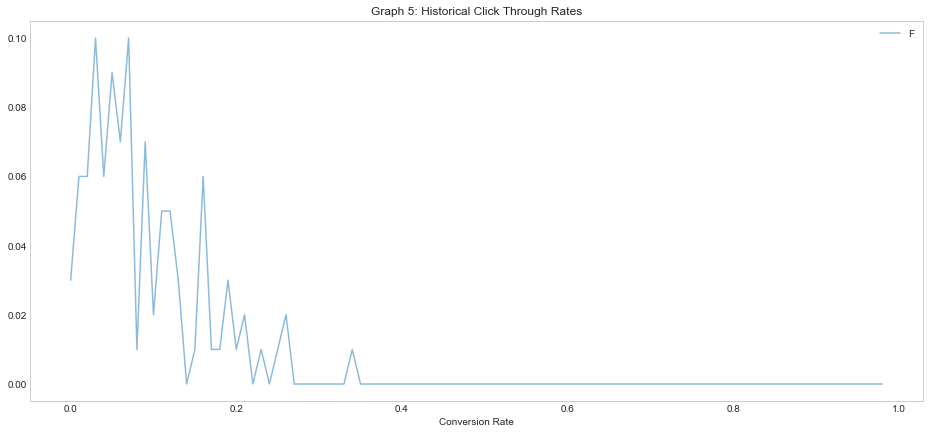

In [14]:
# Historical data on the conversion rates
plt.rcParams['figure.figsize'] = (16, 7)

true_a = 2.06 #alpha parameter of the beta distribution from which we are generating campaigns
true_b = 20 #beta parameter of the beta distribution from which we are generating campaigns

#number of marketing campaigns
N = 100

#randomly generate "true" click through rate for each campaign
p = np.random.beta(true_a,true_b, size=N)

#randomly pick the number of impressions for each campaign
impressions = np.random.randint(1, 10000, size=N)

#sample number of clicks for each campaign
clicks = np.random.binomial(impressions, p).astype(float)
click_through_rates = clicks / impressions

#plot the histogram of previous click through rates with the evidence
#of the new campaign
f, ax = plt.subplots(1)

zero_to_one = [j/100. for j in range(100)]
counts, bins = np.histogram(click_through_rates
                            , bins=zero_to_one)
counts = counts / 100.
ax.plot(bins[:-1],counts, alpha = .5)
#line1, line2, line3 = ax.lines
ax.legend('Frequency of Theta Historically' )
ax.set_xlabel("Conversion Rate")
ax.grid()
ax.set_title("Graph 5: Historical Click Through Rates")
plt.show()

#### <font color = '#3E3E3F'>4.3.2 Estimating beta prior</font>

Below we have to fitted historical conversion rates to a beta ditribution. The reason for specifically choosing a beta distribution requires a bit more of context.

Since we are dealing with distributions here, so to find out the posterior distribution, we are required to multiply the likelihood distribution with a prior distribution in the numerator. And denominator is already a complex integral to solve analytically. Based on the type of probability distibutions we use in the numerator, we might not always be able to get an exact mathematical solution. To solve for this we use two concepts:

1. **Conjugate Priors** - Talking about the numerator from the bayes equation, luckily there exists certain pairs of disribution which shorcircuit bunch of algebra and we are able to derive an exact posterior mathematically. When we multiply two probability distribution functions (in this case likelihood and the prior), and the resulting posterior distribution is also from one of parent family, then we call it a conjugate pair. For example, if a beta probability distribution function is multiplied with a binomial distribution finction, the resulting posterior will also belong to a beta distribution function. 

    Our conversion rates can be modelled as a binomial distribution. 

    $$ P(A) = {{N}\choose{k}} \cdot p^k(1-p)^{N-k}$$

    Here we are essentially saying that - out of total $N$ clicks $k$ got converted with probability of $p$ and $(N-K)$ were not converted with a probability of $(1-p)$. Here, p the the parameter of interest i.e. conversion rate.

    Also, we state our prior belif as a beta distribution. More information description hase been provided 
    <a href="https://www.quantstart.com/articles/Bayesian-Inference-of-a-Binomial-Proportion-The-Analytical-Approach"> here </a>on why and how we decided on the beta distribution. Long story short, if we use this pair, the resulting posterior will also be a beta distribution.


2. **Monte Carlo Markov Chain Simulations** - These are what we call numerical solutions, where (roughly speaking) we randomly sample the likelihood and the proir distribution to derive a posterior distribution. The beauty of this approach is that we don't need to look for a conjugate priors. We can go ahead and select any pair we want. To learn more on MCMC simulaitons, there are really helpful links that I have mentioned in reference section (towards the end of notebook)

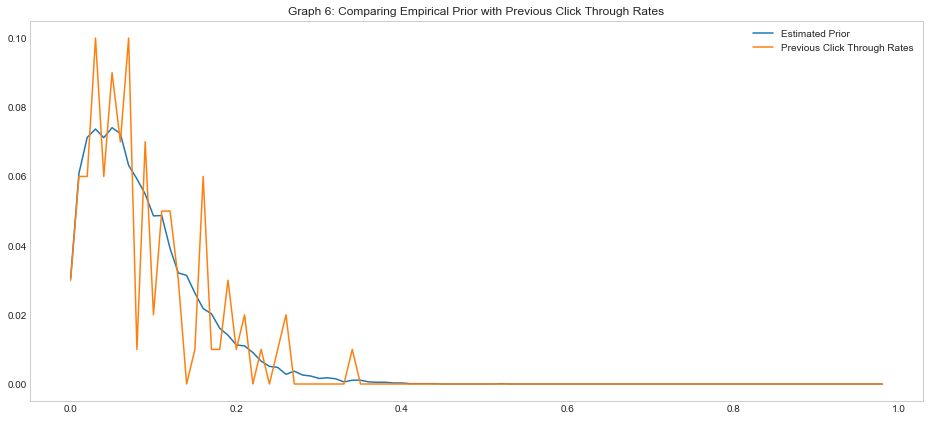

In [15]:
prior_parameters = beta.fit(click_through_rates
                            , floc = 0
                            , fscale = 1)
#extract a,b from fit
alpha_prior, beta_prior = prior_parameters[0:2]

#define prior distribution sample from prior
prior_distribution = beta(alpha_prior, beta_prior)
#get histogram of samples
prior_samples = prior_distribution.rvs(10000)
#get histogram of samples
fit_counts, bins = np.histogram(prior_samples
                                , zero_to_one)
#normalize histogram
fit_counts = list(map(lambda x: float(x)/fit_counts.sum()
                         , fit_counts))

#plot
f, ax = plt.subplots(1)
ax.plot(bins[:-1], fit_counts)
hist_ctr, bins = np.histogram(click_through_rates
                              , zero_to_one)
hist_ctr = list(map(lambda x: float(x)/hist_ctr.sum()
                              , hist_ctr))
ax.plot(bins[:-1], hist_ctr)
estimated_prior, previous_click_through_rates = ax.lines
ax.legend((estimated_prior, previous_click_through_rates)
          ,('Estimated Prior'
            , 'Previous Click Through Rates'))
ax.grid()
ax.set_title("Graph 6: Comparing Empirical Prior with Previous Click Through Rates")
plt.show()

#### <font color = '#3E3E3F'>4.3.3 Finding a posterior distribution for a beta binomial conjugate prior (analytical approach)</font>

In [16]:
#posterior distribution
def posterior(alpha_prior, beta_prior, variant, click_day):    
    
    alpha_prior = alpha_prior
    beta_prior = beta_prior
    
    if variant == 'A':  
        conversions_a = conv_days.loc[conv_days['click_day'] == click_day]['cumu_conv_a'].values[0]
        clicks_a = conv_days.loc[conv_days['click_day'] == click_day]['cumu_click_a'].values[0]
        alpha_posterior = alpha_prior+conversions_a
        beta_posterior = beta_prior + clicks_a - conversions_a
        posterior_beta_distri = stats.beta(alpha_posterior, beta_posterior)
        if click_day == 59:
            print("alpha and beta for posterior dissribution of variant 'A' will be ", 
              alpha_posterior, "and" , beta_posterior)

    elif variant == 'B':
        conversions_b = conv_days.loc[conv_days['click_day'] == click_day]['cumu_conv_b'].values[0]
        clicks_b = conv_days.loc[conv_days['click_day'] == click_day]['cumu_click_b'].values[0]
        alpha_posterior = alpha_prior+conversions_b
        beta_posterior = beta_prior + clicks_b - conversions_b
        posterior_beta_distri = stats.beta(alpha_posterior, beta_posterior)
        if click_day == 59:
            print("alpha and beta for posterior dissribution of variant 'B' will be ", 
              alpha_posterior, "and" , beta_posterior)
        
    else:
        print("pass third argumet as as variant you want i.e. 'A' or 'B' ")
    
    return posterior_beta_distri

###### Note:

This <a href="https://www.johndcook.com/UTMDABTR-005-05.pdf"> paper</a> addresses the problem of evaluating P(X > Y ) where X and Y are independent beta random variables (John Cook's solution)

This could also be done by Monte Carlo Simulations

In [17]:
# This code block is tfor defining a function that can calculate the probabilities between two beta distribution

from math import lgamma
from numba import jit

#defining the functions used
@jit
def h(a, b, c, d):
    num = lgamma(a + c) + lgamma(b + d) + lgamma(a + b) + lgamma(c + d)
    den = lgamma(a) + lgamma(b) + lgamma(c) + lgamma(d) + lgamma(a + b + c + d)
    return np.exp(num - den)
@jit
def g0(a, b, c):    
    return np.exp(lgamma(a + b) + lgamma(a + c) - (lgamma(a + b + c) + lgamma(a)))
@jit
def hiter(a, b, c, d):
    while d > 1:
        d -= 1
        yield h(a, b, c, d) / d
def g(a, b, c, d):
    return g0(a, b, c) + sum(hiter(a, b, c, d))
def calc_prob_between(beta1, beta2):
    return g(beta1.args[0], beta1.args[1], beta2.args[0], beta2.args[1])

#### <font color = '#3E3E3F'>4.3.4 Calculating Posterior from beta binomial prior based on a daily basis and estimating probabilities</font>

In [18]:
daily_cumu_prob = []
for day in range(60):
    a = posterior(alpha_prior,beta_prior,'A',day)
    b = posterior(alpha_prior,beta_prior,'B',day)
    prob=calc_prob_between(b,a)
    daily_cumu_prob.append(prob) 

alpha and beta for posterior dissribution of variant 'A' will be  435.6880734621692 and 5503.527492784307
alpha and beta for posterior dissribution of variant 'B' will be  499.6880734621692 and 5382.527492784307


#### <font color = '#3E3E3F'>4.3.5 Calculating Probability of Variant B being better than A</font>

Text(0.5, 0, 'Click days')

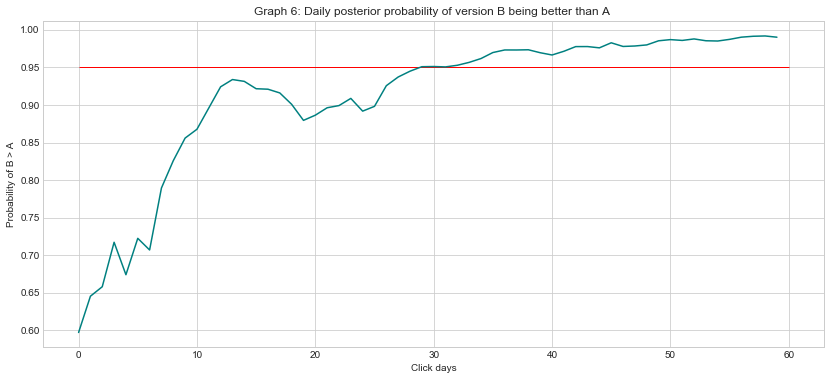

In [19]:
fig, ax =  plt.subplots(figsize=(14,6))

ax.plot(range(60), daily_cumu_prob, color='teal')
ax.hlines(y=0.95, xmin=0, xmax=60, linewidth=1, color='r')
ax.set_title('Graph 6: Daily posterior probability of version B being better than A ')
ax.set_ylabel('Probability of B > A')
ax.set_xlabel('Click days')
#legend = ax.legend(loc = 'best',ncol=1,frameon = True)

> **_*The Graph 6 indicate the probability of version A being better than A on a daily basis as we continue to accumulate more evidence/data*_**

####  <font color = '#3E3E3F'>4.3.6 Lift in conversion rates</font>

In [20]:
#After 30th Day
day1 = 30
a1 = posterior(alpha_prior,beta_prior,'A',day1)
b1 = posterior(alpha_prior,beta_prior,'B',day1)

lift1=(b1.mean()-a1.mean())/a1.mean()
#calculating the probability for Test to be better than Control
prob1=calc_prob_between(b1,a1)

day2 = 59
a2 = posterior(alpha_prior,beta_prior,'A',day2)
b2 = posterior(alpha_prior,beta_prior,'B',day2)

lift2=(b2.mean()-a2.mean())/a2.mean()
#calculating the probability for Test to be better than Control
prob2=calc_prob_between(b2,a2)

print("After day 30: Lift from variant B is {0:.2f}%, and probability of B being better than A based on data is {1:.2f}%".format(lift1*100, prob1*100))
print("After day 60: Lift from variant B is {0:.2f}%, and probability of B being better than A based on data is {1:.2f}%".format(lift2*100, prob2*100))

alpha and beta for posterior dissribution of variant 'A' will be  435.6880734621692 and 5503.527492784307
alpha and beta for posterior dissribution of variant 'B' will be  499.6880734621692 and 5382.527492784307
After day 30: Lift from variant B is 15.60%, and probability of B being better than A based on data is 95.12%
After day 60: Lift from variant B is 15.80%, and probability of B being better than A based on data is 99.03%


#### <font color = '#3E3E3F'>4.3.7 Running Monte Carlo simulation on 30th day (numerical approach)</font>

In [21]:
click_day = 30
conversions_a = conv_days.loc[conv_days['click_day'] == click_day]['cumu_conv_a'].values[0]
clicks_a = conv_days.loc[conv_days['click_day'] == click_day]['cumu_click_a'].values[0]
conversions_b = conv_days.loc[conv_days['click_day'] == click_day]['cumu_conv_b'].values[0]
clicks_b = conv_days.loc[conv_days['click_day'] == click_day]['cumu_click_b'].values[0]

with pm.Model() as model:
        
    p_A = pm.Beta("p_A", alpha_prior, beta_prior)
    p_B = pm.Beta("p_B",alpha_prior, beta_prior)

    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_B - p_A)

with model:
    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Binomial("obs_A", p=p_A, n = clicks_a, observed=conversions_a)
    obs_B = pm.Binomial("obs_B", p=p_B, n = clicks_b, observed=conversions_b)

    step = pm.Metropolis()
    trace_1 = pm.sample(20000, step=step, progressbar = True)
    burned_trace_1=trace_1[1000:]

    p_A_samples_1 = burned_trace_1["p_A"]
    p_B_samples_1 = burned_trace_1["p_B"]
    delta_samples_1 = burned_trace_1["delta"]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:15<00:00, 5130.17draws/s]
The number of effective samples is smaller than 10% for some parameters.


It should be noted that we can also run MCMC in loop to iterate over all 30 days

#### <font color = '#3E3E3F'>4.3.8 A closer look at the outputs of PyMC3 MCMC simulation: Posterior distribution, credible interval and trace plots</font>

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c21484b50>],
      dtype=object)

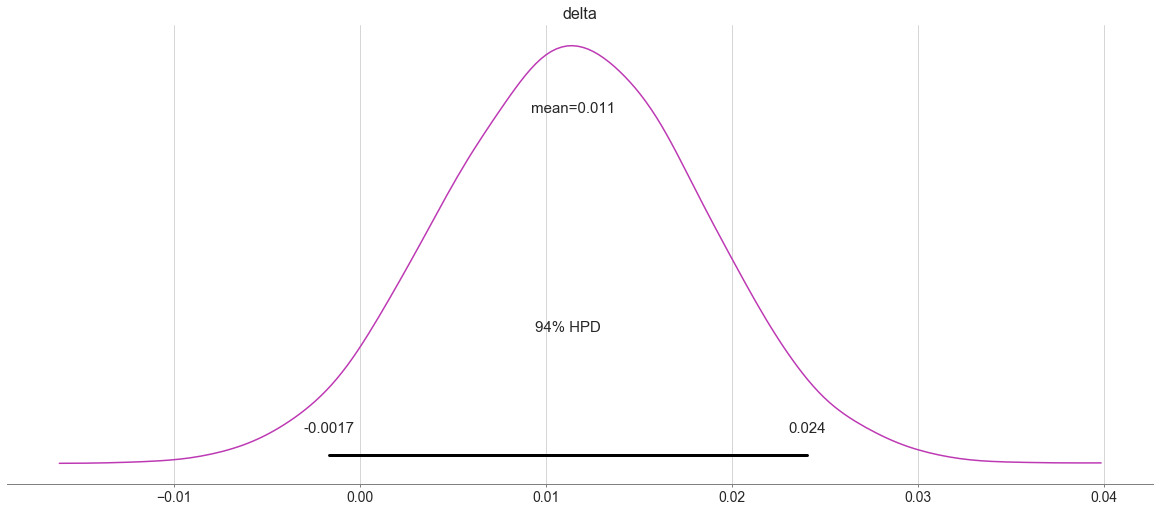

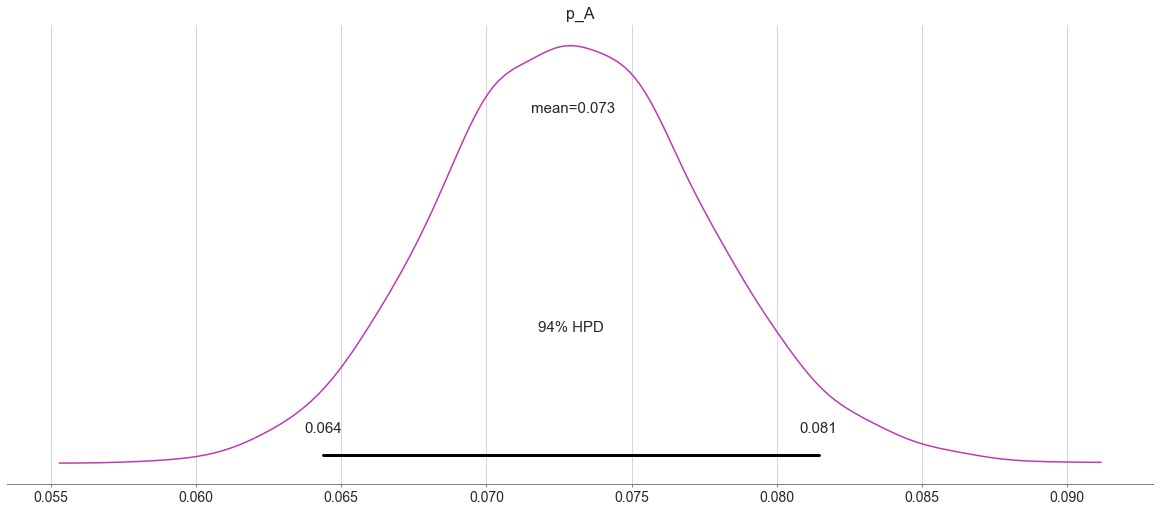

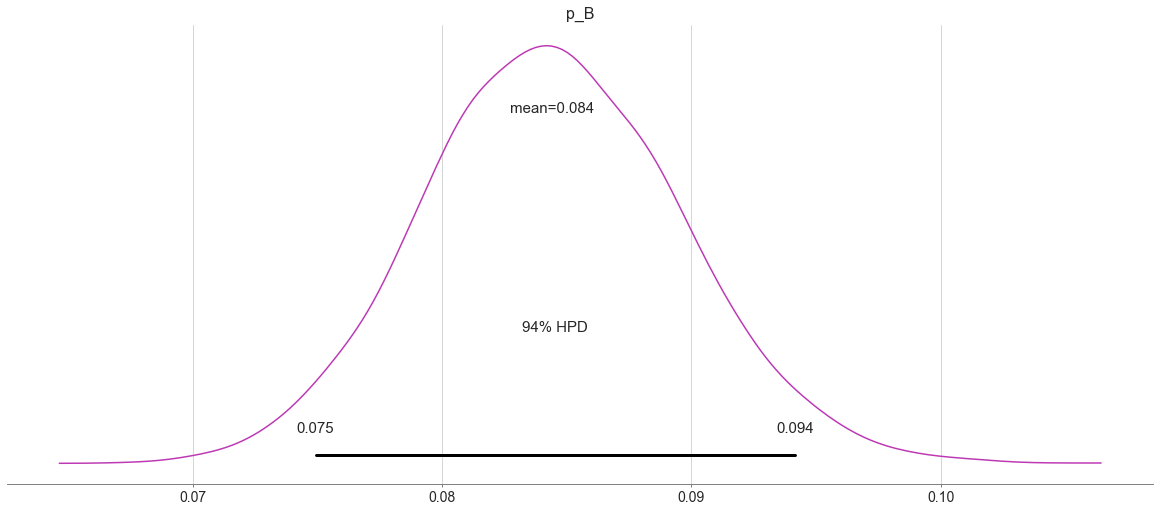

In [22]:
import arviz as az

az.plot_posterior(burned_trace_1, var_names=['delta'],color='#BD39B4')
az.plot_posterior(burned_trace_1, var_names=['p_A'],color='#BD39B4')
az.plot_posterior(burned_trace_1, var_names=['p_B'],color='#BD39B4')

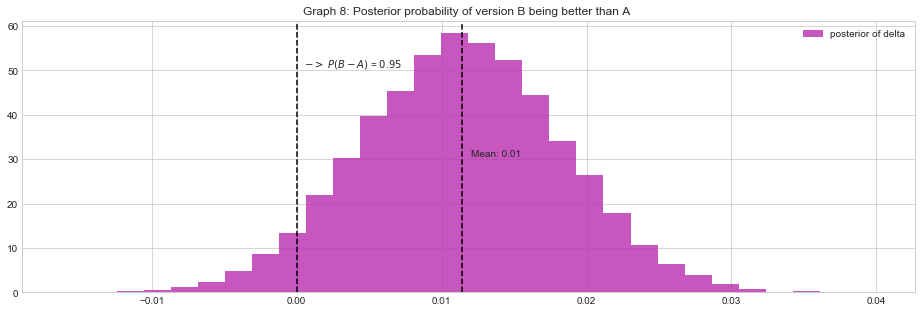

In [59]:
# another view of posterior distribution of delta
import warnings
warnings.filterwarnings('ignore')
plt.figure( figsize = ( 16, 5 ) )
plt.hist( delta_samples_1, histtype = 'stepfilled', bins = 30, alpha = 0.85,
          label = "posterior of delta", color = "#BD39B4", normed = True )
plt.axvline( x = 0.0, color = "black", linestyle = "--" )
plt.axvline(delta_samples_1.mean(), color='k', linestyle='--')
min_ylim, max_ylim = plt.ylim()
plt.text(delta_samples_1.mean()*1.05, max_ylim*0.5, 'Mean: {:.2f}'.format(delta_samples_1.mean()))
plt.text(0.0005, max_ylim*0.83, '$->$ $P(B - A)$ = ${:.2f}$'.format(np.mean(delta_samples_1>0)))
plt.title('Graph 8: Posterior probability of version B being better than A ')
plt.legend(loc = "upper right")
plt.show()

With respect to the posterior distribution of delta, we can see that the majority of the distribution is above delta=0, implying there site B's response is likely better than site A's response. The probability this inference is correct is calculated below.

If this probability is too high for comfortable decision-making, we can perform more trials on site B (as site B has less samples to begin with, each additional data point for site B contributes more inferential "power" than each additional data point for site A).

#### <font color = '#3E3E3F'>4.3.9 The probability of "B" being better than "A" - Numerical / MCMC Solution</font>

In [27]:
lift_mcmc=(p_B_samples_1.mean()-p_A_samples_1.mean())/p_A_samples_1.mean()
print('The probability of version B being better than version A is {:.2f}%'.format(np.mean(delta_samples_1>0)*100))
print('Conversion lift from variant B is {:.2f}% (of 0.07)'.format(lift_mcmc*100))
print('Mean conversion rate from B is {:.2f}% and that from A is {:.2f}%'.format(p_B_samples_1.mean()*100,p_A_samples_1.mean()*100))

The probability of version B being better than version A is 95.22%
Conversion lift from variant B is 15.66% (of 0.07)
Mean conversion rate from B is 8.44% and that from A is 7.30%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c200cd390>,
      dtype=object)

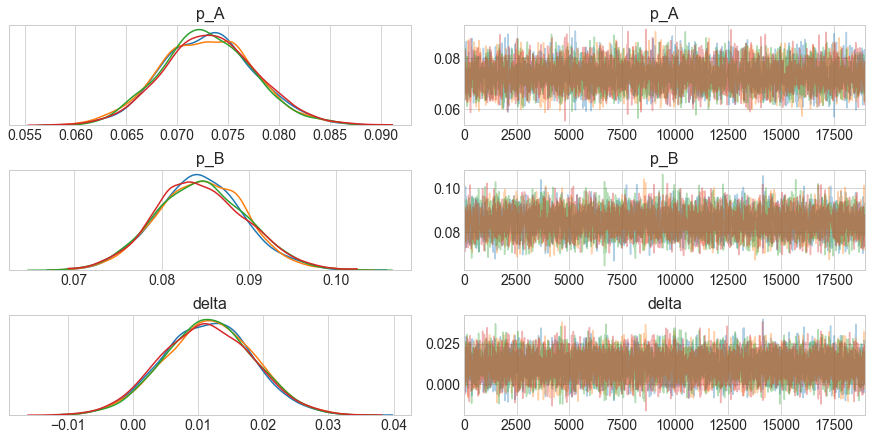

In [28]:
# traceplot to check the convergence of MCMC
az.plot_trace(burned_trace_1)

In [29]:
pm.summary(trace_1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p_A,0.072988,0.004551,0.000057,0.064325,0.082290,7550.410022,1.000612
p_B,0.084406,0.005109,0.000062,0.074610,0.094559,8227.907773,1.000153
delta,0.011418,0.006879,0.000086,-0.002627,0.024347,8074.745724,1.000646


## <font color='brown'>5. Recommendations and Next Steps</font> 

### <font color='teal'>5.1 Recommendations</font> 

<font color='#4A615E'><b>1. Organizations should smoothly transition from frequentist methods to Bayesian methods. Since it is important to develop confidence within any org around this methodology, both bayesian and frequentist calculations should be carried out simultaneously in the early stages of transition. This notebook offers a basic structure of how could this be achieved</b></font> 

 <font color='#4A615E'><b>2. There are aprehensions around methodology for selecting prior ditribution in bayesian frameworks. To tackle this, Product Managers should be actively involved to mould this prior information with the help of their experience, intution and historic data. This notebook has demonstrated one such example.</b></font> 

 <font color='#4A615E'><b>3. This framework can very well be used outside A/B testing i.e for general hypothesis testing</b></font>

### <font color='teal'>5.2 Next steps</font> 

It should be noted that we haven't discussed anything around the sample size estimation in Bayesian framework. Recently in 2017 and 2018 there have been couple of relevant <a href="https://link.springer.com/article/10.3758%2Fs13423-017-1230-y"> white papers</a> that discuss in detail about how we can plan better for compelling evidence. 

Thus, the next steps are to:

 <font color='#4A615E'><b>1. Make a framework to explore Bayes Factor Design Analysis (BFDA) to design experiments for maximum efficiency and informativeness</b></font> 

 <font color='#4A615E'><b>2. Compare hypothesis testing through sequential bayes factor and Null hypothesis significance testing. These methods are primarily developed for psychological studies, but can very well be adopted by organizations for experimentation</b></font> 



## <font color='brown'>6. References</font> 

I have read numerous blogs and white papers to understand bayesian methods. When I started, My view of the bayesian inference was something of a "magic fix". I needed a code where I can feed the data and can get an output like "Probability of 'A' being beter than 'B' is x%"

Before I could use, understand and apply this magic fix, I came across the following painful buzz words like **informed and uninformed Prior, Posterior, Likelihood, Marginal likelihood, Bayes factor, Conjugate prior, Markov Chain Monte Carlo Simulations, false positive rate (rejecting null hypothesis when it was actually true), false negative rate (failing to reject the null hypothesis when it was actually false)**

Hence, I want to provide a relevant list of references that one can go through to understand the Bayesian framework from scratch:

1. A simple introduction to Markov-chain Monte Carlo sampling - https://link.springer.com/article/10.3758/s13423-016-1015-8 </p>
2. Bayesian statistics -  A Beginner’s guide - https://www.quantstart.com/articles/Bayesian-Statistics-A-Beginners-Guide
3. Bayesian Inference of a Binomial Proportion - The Analytical Approach - https://www.quantstart.com/articles/Bayesian-Inference-of-a-Binomial-Proportion-The-Analytical-Approach
4. Markov Chain Monte Carlo for Bayesian Inference - The Metropolis Algorithm-  https://www.quantstart.com/articles/Markov-Chain-Monte-Carlo-for-Bayesian-Inference-The-Metropolis-Algorithm
5. Statsthinking21 - http://statsthinking21.org/bayesian-statistics.html#bayesian-hypothesis-testing
6. Michael Franke gihub profile - difference between posterior probability of parameter vs posterior probability of a model -  https://michael-franke.github.io/statistics,/modeling/2017/07/07/BF_computation.html
7. Oracle blog - https://blogs.oracle.com/datascience/introduction-to-bayesian-inference
8. Step by step guide for bayesian analysis - http://www.claudiobellei.com/2017/11/02/bayesian-AB-testing/
9. Bayesian A/B testing from scratch - https://www.kaggle.com/cstorm3000/bayesian-a-b-testing-from-scratch
10. Bayes theorem, likelihood and marginal likelihood - http://www.stat.cmu.edu/~larry/=sml/Bayes.pdf
11. Bayesian Estimation Supersedes the T-Test -https://nbviewer.jupyter.org/github/JWarmenhoven/pymc3/blob/master/docs/source/notebooks/BEST.ipynb
12. Bayesian method for Hackers - https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC3.ipynb
13. Vincenzo Lavorini's article on bayesian A/B testing - https://towardsdatascience.com/bayesian-a-b-testing-with-python-the-easy-guide-d638f89e0b8a
14. Analyzing conversion rates with Bayesian rule - https://www.chrisstucchio.com/blog/2013/bayesian_analysis_conversion_rates.html
15. Bayes factor design analysis: Planning for compelling evidence - https://link.springer.com/article/10.3758%2Fs13423-017-1230-y
16. Sequential hypothesis testing for Bayes factors - Sequential Hypothesis Testing With Bayes Factors - OSF
https://osf.io › download
17. Is Bayesian A/B Testing Immune to Peeking? Not Exactly - http://varianceexplained.org/r/bayesian-ab-testing/
18. The Bayesian New Statistics: Hypothesis testing, estimation, meta-analysis, and power analysis from a Bayesian perspective - https://link.springer.com/article/10.3758/s13423-016-1221-4
19. Frequentist approach - Ethen's learning repository - https://github.com/ethen8181/machine-learning